# Setup and Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

%matplotlib inline

#    Uploads a CSV file from several possible paths:
    - absolute path
    - current directory
    - ‘data’ folder on the laptop
    - user's home directory

In [2]:
def load_data(filename: str) -> pd.DataFrame:
    path = Path(filename)
    
    if path.is_absolute() and path.exists():
        print(f"Loading absolute path: {path}")
        return pd.read_csv(path, comment="#")
    
    candidates = [
        Path(filename),
        Path("data") / filename,
        Path.cwd() / filename,
        Path.cwd() / "data" / filename,
        Path.home() / "data" / filename
    ]
    
    for candidate in candidates:
        if candidate.exists():
            print(f"Loading: {candidate}")
            return pd.read_csv(candidate, comment="#")
    
    raise FileNotFoundError(
        f"❌ File '{filename}' not found in any of:\n" + "\n".join(str(p) for p in candidates)
    )

#    Saves the DataFrame in several possible locations:
    - local data folder on the laptop
    - user's home directory in the data subfolder

In [3]:
def save_data(df: pd.DataFrame, filename: str):
    candidates = [
        Path("data"),
        Path.home() / "data"
    ]
    
    for base in candidates:
        try:
            base.mkdir(parents=True, exist_ok=True)
            out_path = base / filename
            df.to_csv(out_path, index=False)
            print(f"✅ File saved to: {out_path}")
            return
        except Exception as e:
            print(f"⚠️ Could not save to {base}: {e}")
    
    raise IOError("❌ Failed to save the file in any of the candidate locations.")

# Core dataset for Model




## Select minimal set of relevant columns

In [4]:
koi = load_data("raw/KOI_raw_2025.10.01.csv")

needed_cols = [
    "kepoi_name",
    "koi_disposition",
    "koi_period",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag"
]

koi_learning = koi[needed_cols].copy()
koi_learning

Loading: data/raw/KOI_raw_2025.10.01.csv


,kepoi_name,koi_disposition,koi_period,koi_duration,koi_depth,koi_prad,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,K00752.01,CONFIRMED,9.488036,2.95750,615.8,2.26,5455.0,4.467,0.927,15.347
1,K00752.02,CONFIRMED,54.418383,4.50700,874.8,2.83,5455.0,4.467,0.927,15.347
2,K00753.01,CANDIDATE,19.899140,1.78220,10829.0,14.60,5853.0,4.544,0.868,15.436
3,K00754.01,FALSE POSITIVE,1.736952,2.40641,8079.2,33.46,5805.0,4.564,0.791,15.597
4,K00755.01,CONFIRMED,2.525592,1.65450,603.3,2.75,6031.0,4.438,1.046,15.509
...,...,...,...,...,...,...,...,...,...,...
9559,K07985.01,FALSE POSITIVE,0.527699,3.22210,1579.2,29.35,5638.0,4.529,0.903,14.082
9560,K07986.01,CANDIDATE,1.739849,3.11400,48.5,0.72,6119.0,4.444,1.031,14.757
9561,K07987.01,FALSE POSITIVE,0.681402,0.86500,103.6,1.07,6173.0,4.447,1.041,15.385
9562,K07988.01,CANDIDATE,333.486169,3.19900,639.1,19.30,4989.0,2.992,7.824,10.998


In [5]:
print(koi_learning.info())
print(koi_learning.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepoi_name       9564 non-null   object 
 1   koi_disposition  9564 non-null   object 
 2   koi_period       9564 non-null   float64
 3   koi_duration     9564 non-null   float64
 4   koi_depth        9201 non-null   float64
 5   koi_prad         9201 non-null   float64
 6   koi_steff        9201 non-null   float64
 7   koi_slogg        9201 non-null   float64
 8   koi_srad         9201 non-null   float64
 9   koi_kepmag       9563 non-null   float64
dtypes: float64(8), object(2)
memory usage: 747.3+ KB
None
          koi_period  koi_duration     koi_depth       koi_prad     koi_steff  \
count    9564.000000   9564.000000  9.201000e+03    9201.000000   9201.000000   
mean       75.671358      5.621606  2.379134e+04     102.891778   5706.823280   
std      1334.744046      6.471554  8.2

## Missing Value Handling

In [6]:
missing = koi_learning.isna().sum()
missing_percent = (missing / len(koi_learning)) * 100

missing_table = pd.DataFrame({
    "Missing Values": missing,
    "Percent (%)": missing_percent
})

print(missing_table)


                 Missing Values  Percent (%)
kepoi_name                    0     0.000000
koi_disposition               0     0.000000
koi_period                    0     0.000000
koi_duration                  0     0.000000
koi_depth                   363     3.795483
koi_prad                    363     3.795483
koi_steff                   363     3.795483
koi_slogg                   363     3.795483
koi_srad                    363     3.795483
koi_kepmag                    1     0.010456


# Data Cleaning and Missing Value Imputation for KOI Dataset

In [7]:
initial_rows = len(koi_learning)
initial_cols = len(koi_learning.columns)

missing_control_df = pd.DataFrame(index=needed_cols)
missing_control_df["Before Imputation"] = koi_learning.isnull().sum()
print("Missing values before imputation:")
print(missing_control_df)

rows_dropped = koi_learning["koi_kepmag"].isnull().sum() 
koi_learning = koi_learning.dropna(subset=["koi_kepmag"]).copy()

assert 'NOT DISPOSITIONED' not in koi_learning['koi_disposition'].unique(), "The 'NOT DISPOSITIONED' value is still present."

cols = ["koi_depth", "koi_prad", "koi_srad", "koi_steff", "koi_slogg"]
imputed_cols = [f"{col}_missing" for col in cols] 

for col in cols:
    koi_learning.loc[:, f"{col}_missing"] = koi_learning[col].isna().astype("int8")
    koi_learning.loc[:, col] = koi_learning[col].fillna(koi_learning[col].mode()[0])

missing_control_df["After Imputation"] = koi_learning.isnull().sum()
print("\nMissing values after imputation:")
print(missing_control_df)

save_data(koi_learning, "cleaned/KOI_clean_for_learning.csv")


Missing values before imputation:
                 Before Imputation
kepoi_name                       0
koi_disposition                  0
koi_period                       0
koi_duration                     0
koi_depth                      363
koi_prad                       363
koi_steff                      363
koi_slogg                      363
koi_srad                       363
koi_kepmag                       1

Missing values after imputation:
                 Before Imputation  After Imputation
kepoi_name                       0                 0
koi_disposition                  0                 0
koi_period                       0                 0
koi_duration                     0                 0
koi_depth                      363                 0
koi_prad                       363                 0
koi_steff                      363                 0
koi_slogg                      363                 0
koi_srad                       363                 0
koi_kepmag       

## Outlier Handling

<Figure size 1200x600 with 0 Axes>

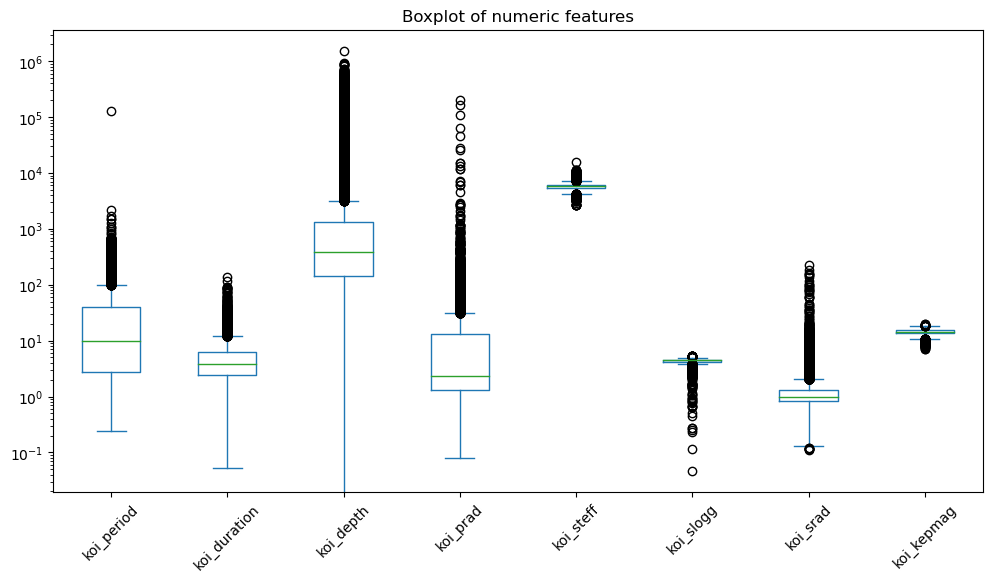

In [8]:
# Visualization of numeric columns to identify skewed distributions and potential outliers.
num_cols = ["koi_period","koi_duration","koi_depth","koi_prad",
            "koi_steff","koi_slogg","koi_srad","koi_kepmag"]

plt.figure(figsize=(12,6))
koi_learning[num_cols].plot(kind="box", subplots=False, logy=True, figsize=(12,6))
plt.title("Boxplot of numeric features")
plt.xticks(rotation=45)
plt.show()


In [9]:
# Log Transformation of skewed features
log_cols = ["koi_period", "koi_depth", "koi_prad", "koi_srad"]

for col in log_cols:
  koi_learning.loc[:, f"{col}_log"] = np.log1p(koi_learning[col])

assert np.all(np.isfinite(koi_learning[[f"{col}_log" for col in log_cols]].values)), "Log-transformed values contain non-finite numbers."

save_data(koi_learning, "cleaned/KOI_clean_for_learning.csv")

✅ File saved to: data/cleaned/KOI_clean_for_learning.csv


<Figure size 1200x600 with 0 Axes>

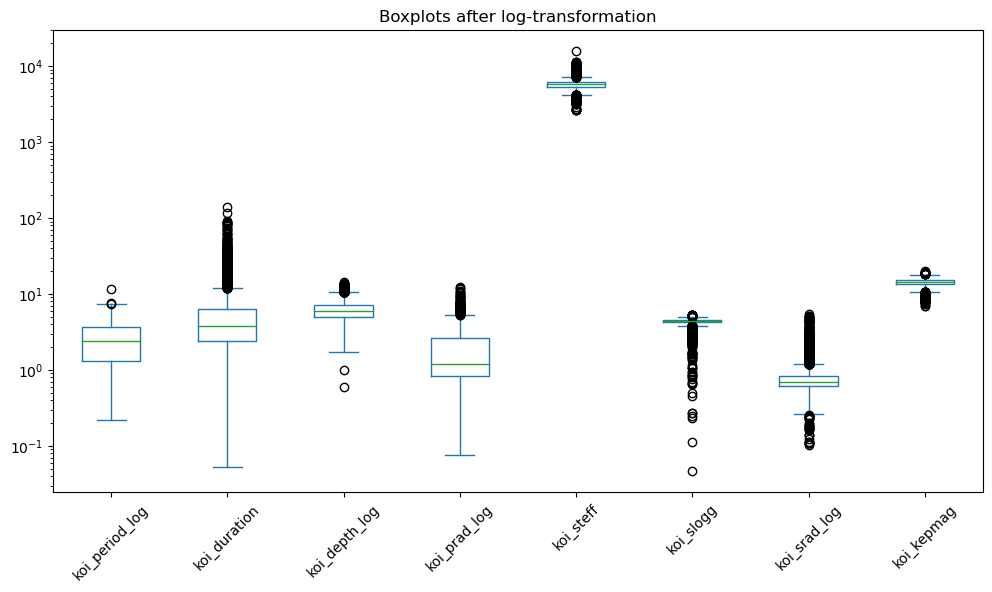

In [10]:
final_cols = ["koi_period_log", "koi_duration", "koi_depth_log", "koi_prad_log", "koi_steff",
              "koi_slogg", "koi_srad_log", "koi_kepmag"]

assert all(col in koi_learning.columns for col in final_cols), "Some of the required columns are missing from the dataframe."

plt.figure(figsize=(12,6))
koi_learning[final_cols].plot(kind="box", logy=True, figsize=(12,6))
plt.title("Boxplots after log-transformation")
plt.xticks(rotation=45)
plt.show()

In [11]:
koi_learning.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9563 entries, 0 to 9563
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepoi_name         9563 non-null   object 
 1   koi_disposition    9563 non-null   object 
 2   koi_period         9563 non-null   float64
 3   koi_duration       9563 non-null   float64
 4   koi_depth          9563 non-null   float64
 5   koi_prad           9563 non-null   float64
 6   koi_steff          9563 non-null   float64
 7   koi_slogg          9563 non-null   float64
 8   koi_srad           9563 non-null   float64
 9   koi_kepmag         9563 non-null   float64
 10  koi_depth_missing  9563 non-null   int8   
 11  koi_prad_missing   9563 non-null   int8   
 12  koi_srad_missing   9563 non-null   int8   
 13  koi_steff_missing  9563 non-null   int8   
 14  koi_slogg_missing  9563 non-null   int8   
 15  koi_period_log     9563 non-null   float64
 16  koi_depth_log      9563 non-n

In [12]:
save_data(koi_learning, "cleaned/KOI_clean_for_learning.csv")

✅ File saved to: data/cleaned/KOI_clean_for_learning.csv


# Extended dataset with Optional columns

In [13]:
# Define optional diagnostic/flag columns
optional_cols = ["koi_impact", "koi_model_snr",
                 "koi_fpflag_nt", "koi_fpflag_ss",
                 "koi_fpflag_co","koi_fpflag_ec"]

koi_extended = koi_learning.copy()

for col in optional_cols:
    if col in koi.columns:
        koi_extended[col] = koi[col]

save_data(koi_extended, "cleaned/KOI_clean_with_optional.csv")

koi_extended.info()

✅ File saved to: data/cleaned/KOI_clean_with_optional.csv
<class 'pandas.core.frame.DataFrame'>
Index: 9563 entries, 0 to 9563
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepoi_name         9563 non-null   object 
 1   koi_disposition    9563 non-null   object 
 2   koi_period         9563 non-null   float64
 3   koi_duration       9563 non-null   float64
 4   koi_depth          9563 non-null   float64
 5   koi_prad           9563 non-null   float64
 6   koi_steff          9563 non-null   float64
 7   koi_slogg          9563 non-null   float64
 8   koi_srad           9563 non-null   float64
 9   koi_kepmag         9563 non-null   float64
 10  koi_depth_missing  9563 non-null   int8   
 11  koi_prad_missing   9563 non-null   int8   
 12  koi_srad_missing   9563 non-null   int8   
 13  koi_steff_missing  9563 non-null   int8   
 14  koi_slogg_missing  9563 non-null   int8   
 15  koi_period_log     

# Data card summarizing the final dataset in markdown format
### Data Card: KOI Cleaned Dataset

**Source Date:** 2025.10.01 (Raw data)

**Key Fields:**
- `kepoi_name`: Kepler Object of Interest identifier
- `koi_disposition`: Label for the candidate (CANDIDATE, FALSE POSITIVE, CONFIRMED)
- `koi_period`: Orbital Period [days]
- `koi_duration`: Transit Duration [hours]
- `koi_depth`: Transit Depth [parts per million]
- `koi_prad`: Planetary Radius [Earth radii]
- `koi_steff`: Stellar Effective Temperature [K]
- `koi_slogg`: Stellar Surface Gravity [log10(cm/s^2)]
- `koi_srad`: Stellar Radius [Solar radii]
- `koi_kepmag`: Kepler Magnitude [mag]

**Derived Fields:**
- `*_missing`: Binary flags indicating imputed values
- `*_log`: Log-transformed numeric features to handle skewness

**Known Limitations:**
- Data represents a snapshot as of 2025.10.01 and may be subject to future updates.
- Some features had missing values, which were imputed with the mode. This might introduce a slight bias.
- The `koi_disposition` column is a simplified label for the purpose of this analysis. More detailed classifications may exist in other datasets.
- Log transformations were applied to address skewed distributions, which may affect the interpretability of raw values.